In [3]:
import os, importlib, sys, time

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
import scipy.linalg as la
import scipy.stats as stats

In [6]:
import pyarrow

# 1. parameters

In [7]:
T = 120
T0 = 40

In [8]:
GPi = np.load('data/GPi.npz')

## observation parameters

In [9]:
pi = np.zeros(T+T0)
pi[:min(GPi['pi'].shape[0], T+T0)] = GPi['pi'][:min(GPi['pi'].shape[0], T+T0)]
alpha = 0.01
r_Y = 10

$$Y_t = NegBinom( \frac{EY_t}{r_Y + EY_t}, r_Y )$$

$$ EY_t = \alpha\sum_{s=1}^{t-1} I_s \pi_{t-s} $$

## latent parameters

In [10]:
g = np.zeros(T+T0)
g[:min(GPi['g'].shape[0], T+T0)] = GPi['g'][:min(GPi['g'].shape[0], T+T0)]

In [11]:
d = 2
beta = np.array([0, -2.2])

In [12]:
r_I = 100
K = 6.5

$$I_t = NegBinom( \frac{EI_t}{r_I + EI_t}, r_I )$$

$$ EI_t = R(\bar{A}_t, \beta) \sum_{s=1}^{t-1} I_s g_{t-s} $$

$$R(\bar{A}_t, \beta) = \frac{K}{1+\exp(- \beta^\top A_t)}$$

## seed values

In [13]:
mu = np.log(100)

$$I_{-T_0} = \mu_0$$

# 2. simulation

In [14]:
num_sim = 1000

## random seed

In [15]:
np.random.seed(1234)

## data generation

In [16]:
I0 = np.full(T0, np.exp(mu))

In [17]:
A = np.stack([np.full(T, 1), 1 * (np.arange(T) > 30)], -1)
R = K / (1 + np.exp(- A @ beta))

In [18]:
Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, np.arange(T)[:,None] - np.arange(T))]
Pi0 = alpha * np.concatenate([[0],pi])[np.maximum(0, np.arange(T)[:,None] - np.arange(-T0,0))]

In [19]:
G = R[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T)[:,None] - np.arange(T))]
G0 = R[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T)[:,None] - np.arange(-T0,0))]

In [20]:
inv_ImG = la.inv(np.eye(T) - G)

In [21]:
EEI = inv_ImG @ (G0 @ I0)

In [22]:
EI = np.zeros((num_sim, T))
I = np.zeros((num_sim, T))

In [23]:
for t in np.arange(T):
    EI[:,t] = G0[t] @ I0 + G[t,:t] @ I[:,:t].T
    I[:,t] = np.random.negative_binomial(r_I, r_I/(r_I+EI[:,t]))

In [24]:
EEY = EEI @ Pi.T + Pi0 @ I0

In [25]:
EY = I @ Pi.T + Pi0 @ I0
Y = np.random.negative_binomial(r_Y, r_Y/(r_Y+EY))

## result

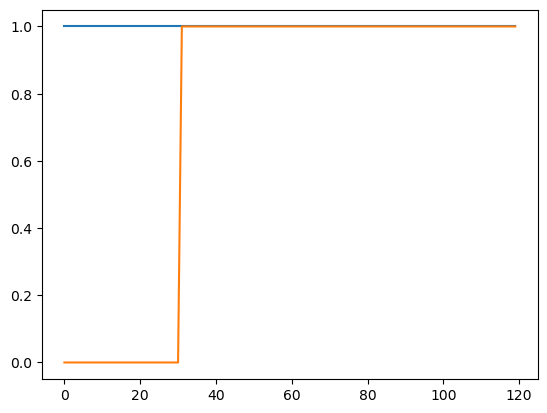

In [26]:
plt.plot(A)

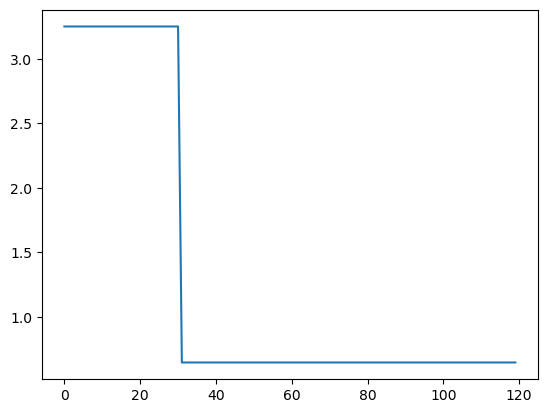

In [27]:
plt.plot(R)

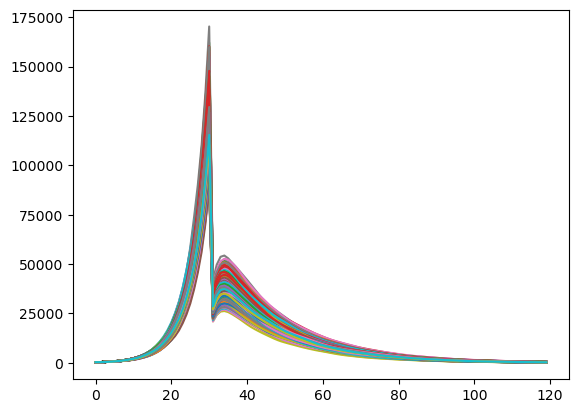

In [28]:
plt.plot(EI.T)
plt.show()

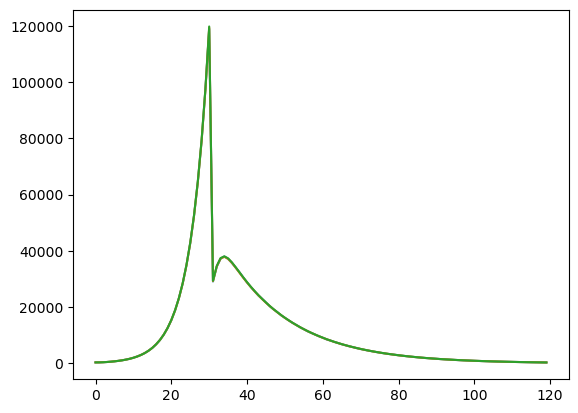

In [29]:
plt.plot(np.mean(I,0))
plt.plot(np.mean(EI,0))
plt.plot(EEI)
plt.show()

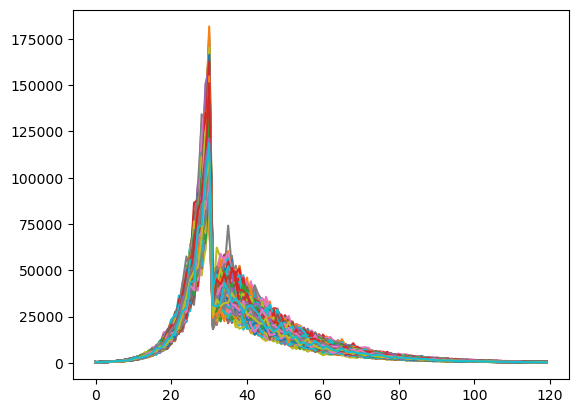

In [30]:
plt.plot(I.T)
plt.show()

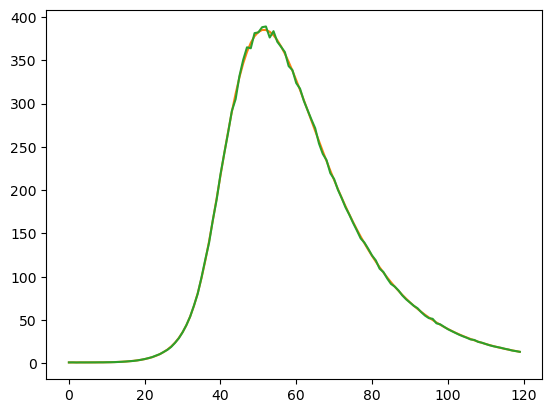

In [31]:
plt.plot(np.mean(EEY, 0))
plt.plot(np.mean(EY, 0))
plt.plot(np.mean(Y, 0))
plt.show()

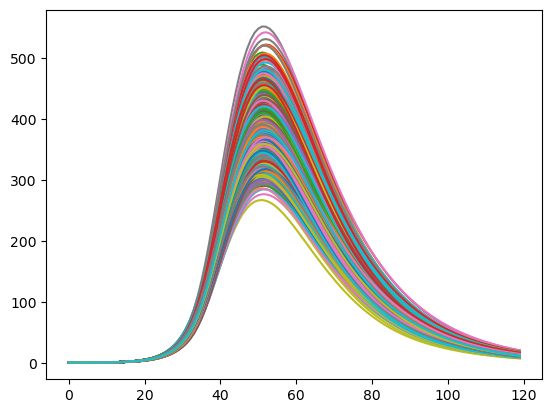

In [32]:
plt.plot(EY.T)
plt.show()

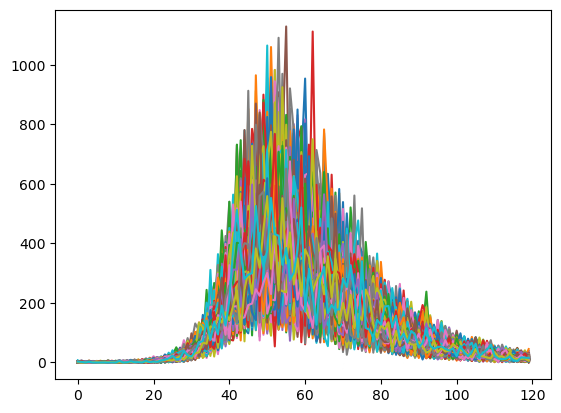

In [33]:
plt.plot(Y.T)
plt.show()

# 3. Save Data

In [34]:
data = {'sim': np.tile(np.arange(num_sim)[:,None], (1,T)).flatten(),
        'date': np.tile(np.arange(T), (num_sim,1)).flatten(),
        'R': np.tile(R, (num_sim,1)).flatten(),
        'EI': EI.flatten(),
        'infection': I.flatten(),
        'EY': EY.flatten(),
        'death': Y.flatten(),
        'intervention': np.tile(A[:,1], (num_sim,1)).flatten()}

In [35]:
df = pd.DataFrame(data)

In [36]:
df

,sim,date,R,EI,infection,EY,death,intervention
0,0,0,3.250000,324.997762,356.0,0.956069,0,0
1,0,1,3.250000,340.245831,298.0,0.962543,2,0
2,0,2,3.250000,392.196621,409.0,0.968283,0,0
3,0,3,3.250000,471.047829,545.0,0.973654,1,0
4,0,4,3.250000,581.900998,584.0,0.979752,1,0
...,...,...,...,...,...,...,...,...
119995,999,115,0.648378,340.371986,323.0,15.832602,7,1
119996,999,116,0.648378,321.865375,276.0,14.876230,5,1
119997,999,117,0.648378,303.169832,255.0,13.980957,17,1
119998,999,118,0.648378,283.911584,265.0,13.142376,16,1


In [37]:
df.to_feather('data/simulation_randinf.feather')